# Loading Data



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import requests
# from bs4 import BeautifulSoup

In [2]:
# My Google Drive was mounted for this notebook; therefore these links are relative to my drive only
MASTER_PATH = "/content/drive/MyDrive/Public Datasets/LIVE DATA - ACTIVITY WISE/"

In [3]:
# Frequency of recording the data
FREQ = 50  # No. of frames per second

In [4]:
# Read the CSV file corresponding to each label into a dataframe and then obtain the final dataframe (df) by concatenating them

# Initialize as an empty dataframe
df = pd.DataFrame()
# Concatenate to collect all the data into the single dataframe
for i in range(1, 10):
    # CSV file's location
    url = MASTER_PATH + str(i) + "_label.csv"
    tempdf = pd.read_csv(url)
    # Concatenate into the existing dataframe
    df = pd.concat([df, tempdf], ignore_index = True)

# Review the obtained dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12509332 entries, 0 to 12509331
Data columns (total 11 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    int64  
 1   acc_x   float64
 2   acc_y   float64
 3   acc_z   float64
 4   gyr_x   float64
 5   gyr_y   float64
 6   gyr_z   float64
 7   mag_x   float64
 8   mag_y   float64
 9   mag_z   float64
 10  label   int64  
dtypes: float64(9), int64(2)
memory usage: 1.0 GB


# Visualizing Data (4s Data)

In [5]:
# Plotting helper function
def plotDev(axes, data, ncol = 0):
    # Determine the title from ncol and set title of the column
    title = ["Accelerometer", "Gyroscope", "Magnetometer"][ncol]
    axes[0, ncol].set_title(title)
    # Determine the prefix of the column name to plot, from ncol
    ypref = ["acc", "gyr", "mag"][ncol]
    # x-axis
    axes[0, ncol].plot(data.index, data[ypref + "_x"], color = "red")
    axes[0, ncol].grid(True)  # Add gridlines
    axes[0, ncol].xaxis.set_visible(False)  # Remove the time ticks
    # y-axis
    axes[1, ncol].plot(data.index, data[ypref + "_y"], color = "blue")
    axes[1, ncol].grid(True)  # Add gridlines
    axes[1, ncol].xaxis.set_visible(False)  # Remove the time ticks
    # z-axis
    axes[2, ncol].plot(data.index, data[ypref + "_z"], color = "green")
    axes[2, ncol].grid(True)  # Add gridlines
    axes[2, ncol].xaxis.set_visible(False)  # Remove the time ticks

In [6]:
# Plotting main function
def plot(label = 1):
    # The subplots objects
    fig, axes = plt.subplots(3, 3, figsize = (18, 6))
    fig.suptitle("Label " + str(label))
    # Get the data corresponding to the label
    labeldf = df[df["label"] == label].iloc[: 4 * FREQ]

    # Plot the x, y and z-axis data (on different rows) of each of accelerometer, gyroscope and magnetometer on different columns
    # Set the labels of the rows to x, y and z-axis respectively
    axes[0, 0].set_ylabel("x-axis")
    axes[1, 0].set_ylabel("y-axis")
    axes[2, 0].set_ylabel("z-axis")
    # Accelerometer
    plotDev(axes, labeldf)
    # Gyroscope
    plotDev(axes, labeldf, 1)
    # Magnetometer
    plotDev(axes, labeldf, 2)
    # Display the plot
    plt.show()

### Label 1

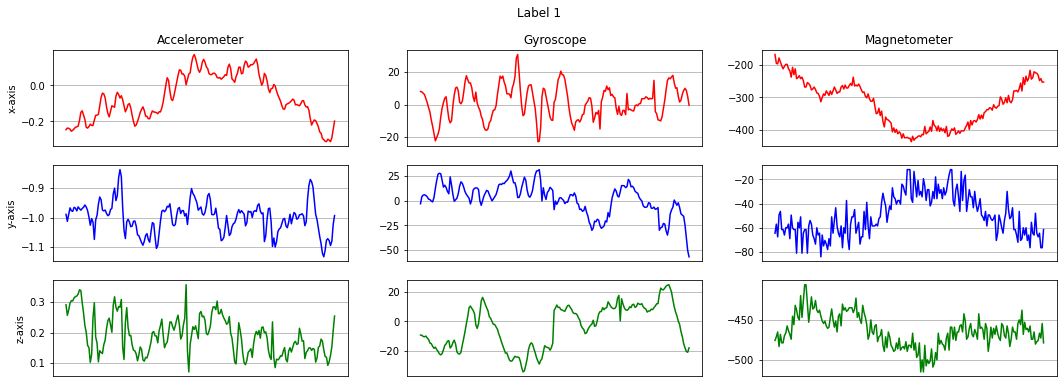

In [7]:
plot()

### Label 2

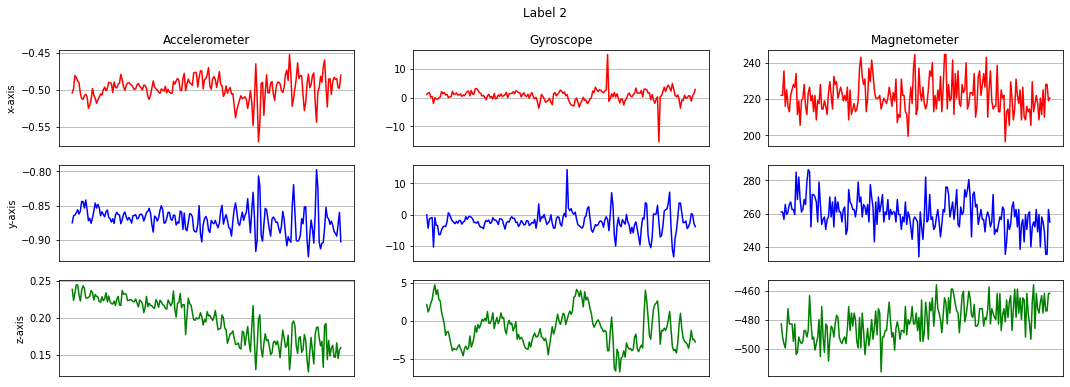

In [8]:
plot(2)

### Label 3

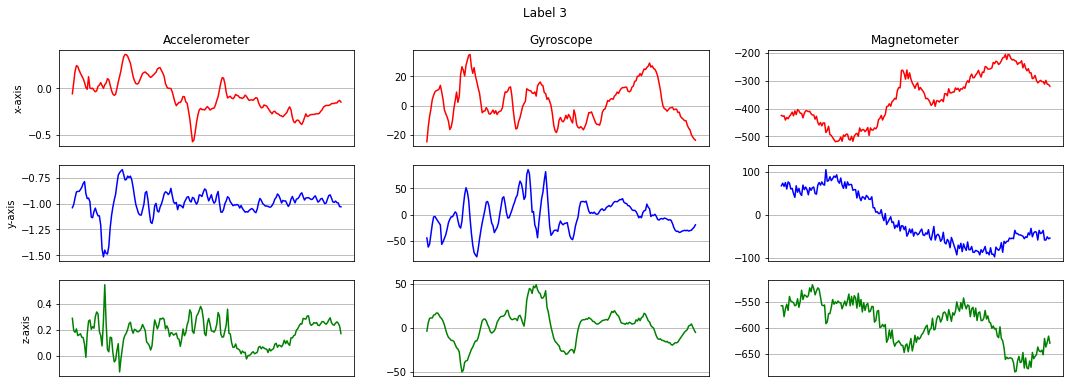

In [9]:
plot(3)

### Label 4

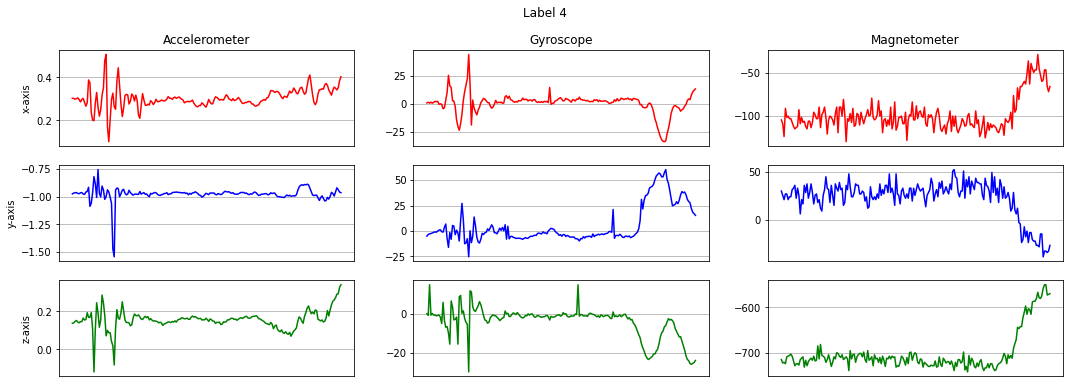

In [10]:
plot(4)

### Label 5

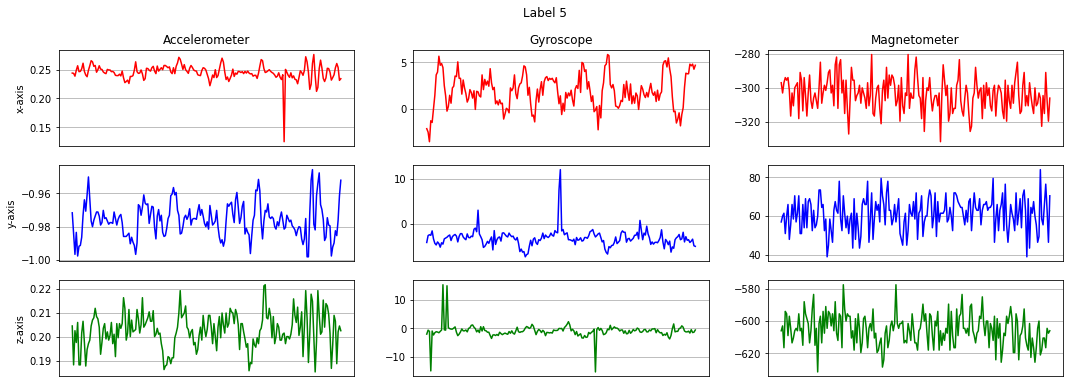

In [11]:
plot(5)

### Label 6

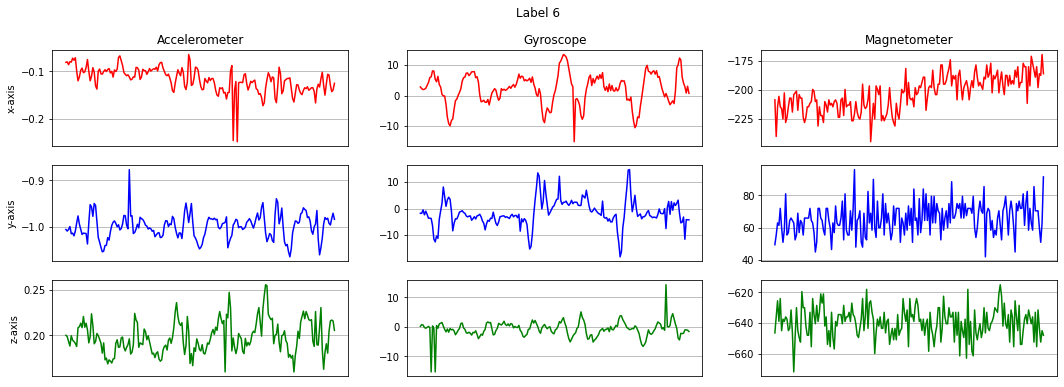

In [12]:
plot(6)

### Label 7

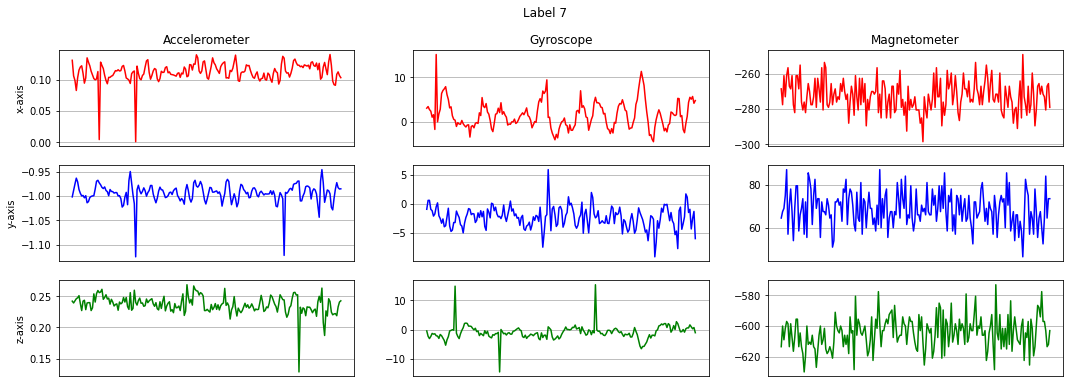

In [13]:
plot(7)

### Label 8

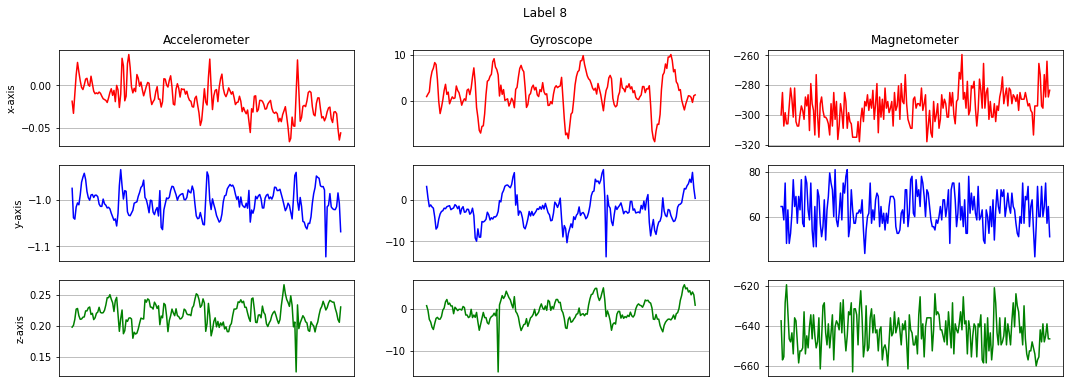

In [14]:
plot(8)

### Label 9

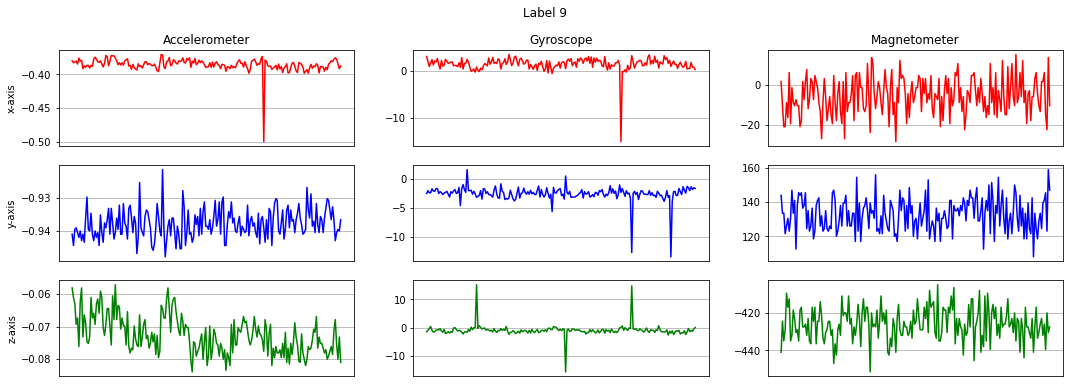

In [15]:
plot(9)

# Preparing Training Data

In [16]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from sklearn.model_selection import train_test_split

In [17]:
# Review data for each label
df.value_counts(["label"])

label
1        3601875
4        3365126
6        1779513
7        1444247
5        1343230
8         482421
9         219736
3         197632
2          75552
dtype: int64

In [18]:
# Number of datapoints of each label to consider for training the data
m = min(df.value_counts(["label"]))
m

75552

In [19]:
# Create a balanced dataset, i.e.,  a dataset with equal number of entries for each label
# Initiate empty dataframe
balanceddf = pd.DataFrame()
# Extract exactly m number of entries of each label and add them as rows to the dataset
for i in range(1, 10):
    tempdf = df[df["label"] == i].head(m).copy()
    balanceddf = pd.concat([balanceddf, tempdf], ignore_index = True)
# Review
balanceddf.value_counts(["label"])

label
9        75552
8        75552
7        75552
6        75552
5        75552
4        75552
3        75552
2        75552
1        75552
dtype: int64

In [20]:
# Standardize data
scaler = StandardScaler()
columns = balanceddf.columns[1 : -1]
scaleddf = pd.DataFrame(scaler.fit_transform(balanceddf[columns]), columns = columns)
# Reduce the label by 1 (labels will range from 0 to 8, both inclusive)
# This will help later during the training of data
scaleddf["label"] = balanceddf["label"] - 1
# Review
scaleddf.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z,label
0,-0.568367,-0.598004,0.547227,0.453410,-0.033409,-0.711198,0.202512,-0.594652,-0.362536,0
1,-0.532091,-0.627300,0.392266,0.436458,0.317300,-0.721606,0.076979,-0.573167,-0.351837,0
2,-0.537818,-0.597394,0.470838,0.381364,0.394575,-0.794464,0.070005,-0.603246,-0.337571,0
3,-0.556912,-0.570539,0.573418,0.317795,0.409435,-0.810077,0.153693,-0.551682,-0.380369,0
4,-0.602735,-0.582746,0.608339,0.152515,0.373770,-0.768443,0.097901,-0.543089,-0.344704,0


In [21]:
# Helper function to get 4s windows of data
def getWindows(X, y):  # X and y are numpy arrays of standardized data
    winsize = FREQ * 4  # 4s corresponds to this number of frames/entries
    skip = FREQ * 2  # Consecutive windows should overlap with a difference of 2s between their initial frames
    windows = []
    labels = []
    for i in range(0, 9 * m - winsize, skip):
        windows.append(X[i : i + winsize])
        labels.append(mode(y[i : i + winsize])[0][0])

    # Return windows and labels corresponding to each window
    windows = np.array(windows)
    labels = np.array(labels)
    return windows, labels

In [22]:
# Prepare the dependent variables and independent variables data and get 4s windows
X = scaleddf[scaleddf.columns[: -1]].values
y = scaleddf["label"].values
windows, labels = getWindows(X, y)
# Check the shapes
windows.shape, labels.shape

((6798, 200, 9), (6798,))

In [23]:
# Reshape the data into a 4D form (each datapoint is of 3 dimensions)
windows = windows.reshape(*windows.shape, 1)
# Check the shape of the data
windows.shape

(6798, 200, 9, 1)

In [24]:
# Split the dataset into training and validation datasets
trainX, validX, trainy, validy = train_test_split(windows, labels, test_size = 0.25, random_state = 0)

In [25]:
trainX.shape

(5098, 200, 9, 1)

# Buiding the Model

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten

In [27]:
# Initialize the CNN model using the sequential API
model = Sequential()
# Add the input layer and a dropout layer
model.add(Conv2D(16, (2, 2), activation = "relu", input_shape = trainX[0].shape))
model.add(Dropout(0.1))  # For regularization
# Add the first hidden layer and its dropout layer
model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(Dropout(0.2))
# Add a flatten layer
model.add(Flatten())
# Add another hidden layer and its dropout layer
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
# Add the output layer
model.add(Dense(9, activation = "softmax"))

In [28]:
# Compile the model
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# Training the Model and Drawing the Learning Curve

In [29]:
history = model.fit(trainX, trainy, epochs = 10, validation_data = (validX, validy), verbose = 1)

Epoch 1/10
160/160 [==============================] - 18s 108ms/step - loss: 1.1338 - accuracy: 0.6230 - val_loss: 0.5502 - val_accuracy: 0.8171
Epoch 2/10
160/160 [==============================] - 17s 104ms/step - loss: 0.6912 - accuracy: 0.7662 - val_loss: 0.4526 - val_accuracy: 0.8600
Epoch 3/10
160/160 [==============================] - 17s 104ms/step - loss: 0.5894 - accuracy: 0.8015 - val_loss: 0.4017 - val_accuracy: 0.8735
Epoch 4/10
160/160 [==============================] - 17s 104ms/step - loss: 0.5080 - accuracy: 0.8244 - val_loss: 0.3823 - val_accuracy: 0.8865
Epoch 5/10
160/160 [==============================] - 17s 104ms/step - loss: 0.4330 - accuracy: 0.8421 - val_loss: 0.3589 - val_accuracy: 0.8841
Epoch 6/10
160/160 [==============================] - 17s 104ms/step - loss: 0.4072 - accuracy: 0.8556 - val_loss: 0.3791 - val_accuracy: 0.8747
Epoch 7/10
160/160 [==============================] - 17s 105ms/step - loss: 0.3491 - accuracy: 0.8713 - val_loss: 0.3583 - val_ac

In [30]:
# Helper function to draw the learning curves
def plotLearningCurves(history, nepochs = 10):
    # Set the figure to be big
    plt.figure(figsize = (18, 6))
    plt.subplot(121)
    # The loss plots
    plt.plot(range(1, nepochs + 1), history.history["loss"])
    plt.plot(range(1, nepochs + 1), history.history["val_loss"])
    plt.legend(["Training", "Validation"])
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(122)
    # The accuracy plots
    plt.plot(range(1, nepochs + 1), history.history["accuracy"])
    plt.plot(range(1, nepochs + 1), history.history["val_accuracy"])
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()

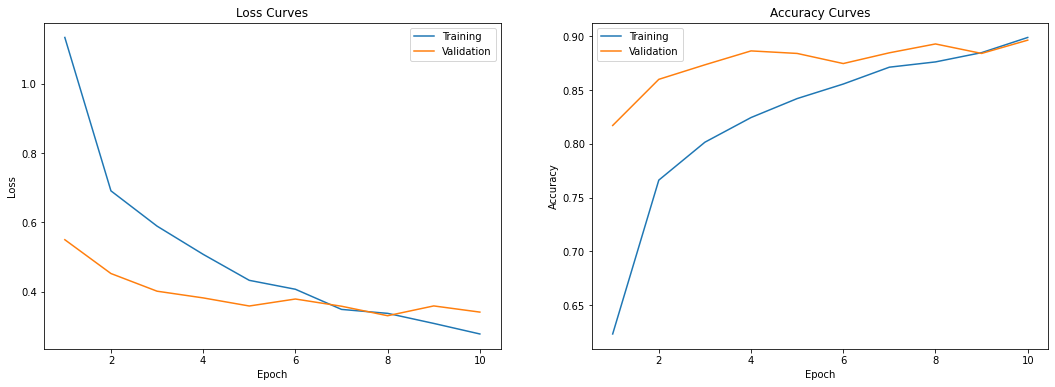

In [31]:
plotLearningCurves(history)

# Evaluate Model Using a Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

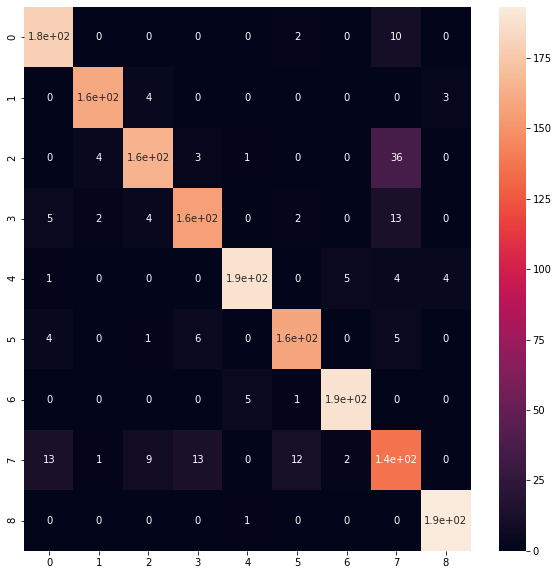

In [33]:
# Obtain the predicted probabilities for the 9 labels for each test data entry
yhat = model.predict(validX)
# Let the prediction for a data point be the label with the max. probability in case of that data point
yhat = np.argmax(yhat, axis = 1)
# Obtain the confusion matrix
cmat = confusion_matrix(validy, yhat)
# Plot the confusion matrix
plt.figure(figsize = (10, 10))
sns.heatmap(cmat, annot = True)

# Saving the Model for Future Use

In [34]:
model.save("/content/drive/MyDrive/Colab Notebooks/Professional/Ranchpal Assignment (Internshala)/cow-activity-model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Professional/Ranchpal Assignment (Internshala)/cow-activity-model/assets
